Author: Syed Sadat Nazrul

Importing Libraries

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

Importing Yahoo Finance data

In [2]:
df_original = pd.read_csv('http://real-chart.finance.yahoo.com/table.csv?s=SPY&d=1&e=12&f=2016&g=d&a=0&b=29&c=1993/spy.csv')
df_original.index = df_original.Date
df_original = df_original.sort_values(by='Date', ascending=True)
df_original.head()

,Date,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,,
1993-01-29,1993-01-29,43.9687,43.9687,43.7500,43.9375,1003200,28.000838
1993-02-01,1993-02-01,43.9687,44.2500,43.9687,44.2500,480500,28.199990
1993-02-02,1993-02-02,44.2187,44.3750,44.1250,44.3437,201300,28.259704
1993-02-03,1993-02-03,44.4062,44.8437,44.3750,44.8125,529400,28.558465
1993-02-04,1993-02-04,44.9687,45.0937,44.4687,45.0000,531500,28.677956


We are only interested in teh adjusted closing stock price

In [3]:
df = df_original[:4000]
df = df[['Adj Close']]
df.head()

,Adj Close
Date,
1993-01-29,28.000838
1993-02-01,28.199990
1993-02-02,28.259704
1993-02-03,28.558465
1993-02-04,28.677956


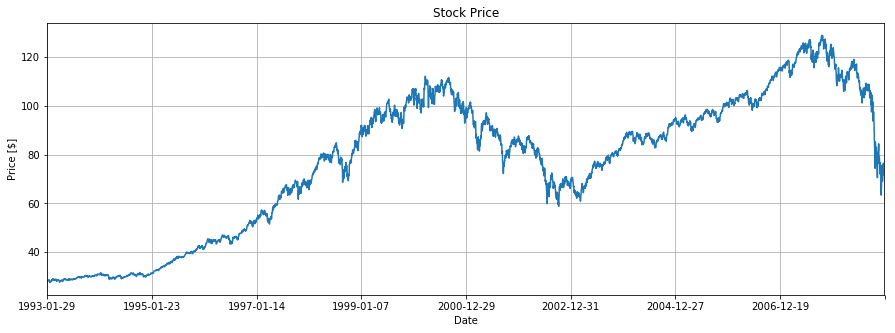

In [4]:
plt.figure(figsize=(15,5))
df['Adj Close'].plot(grid=True)
plt.ylabel('Price [$]')
plt.title('Stock Price');

In order to make the prediction, we will perform FFT on the change in the prices over time

In [5]:
#Add 0 at the beginning to match size
df['delta'] = np.append(np.array([0]),
                        np.diff(df['Adj Close'].values))
df['delta'].head()

Date
1993-01-29    0.000000
1993-02-01    0.199152
1993-02-02    0.059714
1993-02-03    0.298761
1993-02-04    0.119491
Name: delta, dtype: float64

Using FFT, we have calculated our superposition values

In [6]:
sp = np.fft.fft(df['delta'].values)
sp[:10]

array([  46.76802800 +0.j        ,  -21.40389936-32.362434j  ,
       -121.78089672+33.82984354j,  -11.04178695-40.53019507j,
        -71.39948697 +4.27730883j,  -34.51801183-58.19184761j,
        -15.08669758-34.81691691j,   -4.92073753-14.63319363j,
        -10.83903516-64.04120076j,   16.25980298-11.89496223j])

Using the superposition values, we can calculate the theta, amplitude and frequency values

In [7]:
df['theta'] = np.arctan(sp.imag/sp.real)
numValues = len(df)
numValuesHalf = numValues / 2
df['amplitude'] = np.sqrt(sp.real**2 + sp.imag**2)/numValuesHalf
df['freq'] = np.fft.fftfreq(sp.size, d=1)
df.head()

,Adj Close,delta,theta,amplitude,freq
Date,,,,,
1993-01-29,28.000838,0.000000,0.000000,0.023384,0.00000
1993-02-01,28.199990,0.199152,0.986462,0.019400,0.00025
1993-02-02,28.259704,0.059714,-0.270961,0.063196,0.00050
1993-02-03,28.558465,0.298761,1.304818,0.021004,0.00075
1993-02-04,28.677956,0.119491,-0.059835,0.035764,0.00100


The frequency and amplitude values can be used to determine the dominant frequency.
As we know for any Fourier Transform function, we will have a mirror image along the middle (marked in red line).

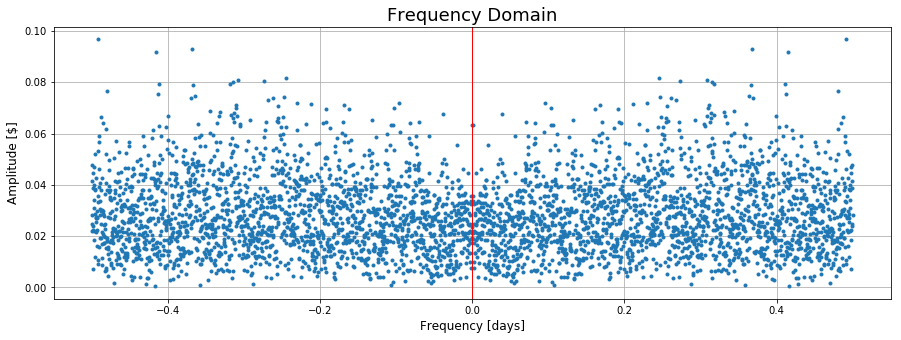

In [8]:
plt.figure(figsize=(15,5))
plt.plot(df['freq'],df['amplitude'].values, '.')
plt.axvline(x=0, ymin=0, ymax = 1, linewidth=1, color='r')
plt.ylabel('Amplitude [$]', fontsize=12)
plt.xlabel('Frequency [days]', fontsize=12)
plt.title('Frequency Domain', fontsize=18)
plt.grid()

For our initial analysis, we will take the left half of the mirror image (positive frequency values) as well as filter out any frequency with an amplitude of over 3 standard deviations.

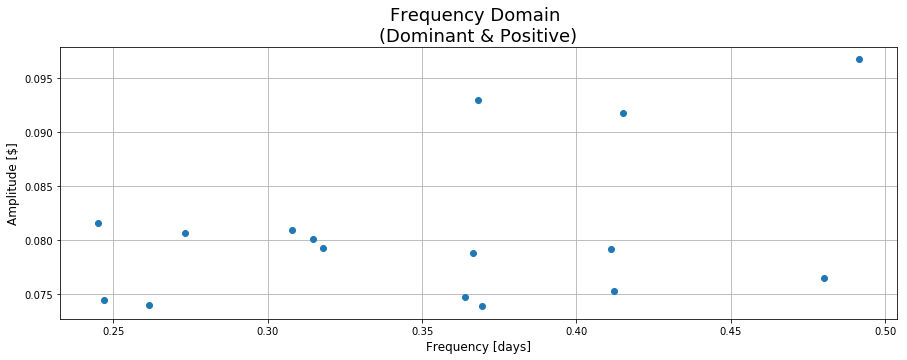

In [9]:
meanAmp = df['amplitude'].mean()
stdAmp = df['amplitude'].std()
dominantAmpCheck = df['amplitude'] > (3*stdAmp + meanAmp) 
positiveFreqCheck = df['freq'] > 0
dominantAmp = df[dominantAmpCheck & positiveFreqCheck]['amplitude']
dominantFreq = df[dominantAmpCheck & positiveFreqCheck]['freq']
dominantTheta = df[dominantAmpCheck & positiveFreqCheck]['theta']

plt.figure(figsize=(15,5))
plt.plot(dominantFreq, dominantAmp, 'o')
plt.ylabel('Amplitude [$]', fontsize=12)
plt.xlabel('Frequency [days]', fontsize=12)
plt.title('Frequency Domain \n(Dominant & Positive)', fontsize=18)
plt.grid();

Using the dominant frequency values, we can attempt to reconstruct the stock prices. 
Since we have been using the time delta, we will perform a cumsum on all the time deltas and add it to the initial adjusting closing stock value to perform a regression.

In [10]:
regressionDelta = 0

for n in range(len(dominantTheta)):
    shift = dominantTheta[n]
    regressionDelta += dominantAmp[n] * np.cos(n * np.array(range(len(df))) + shift)


#Converting Delta Time to Time at start value of real data    
startValue = df['Adj Close'][0]
regression = startValue + np.cumsum(regressionDelta)

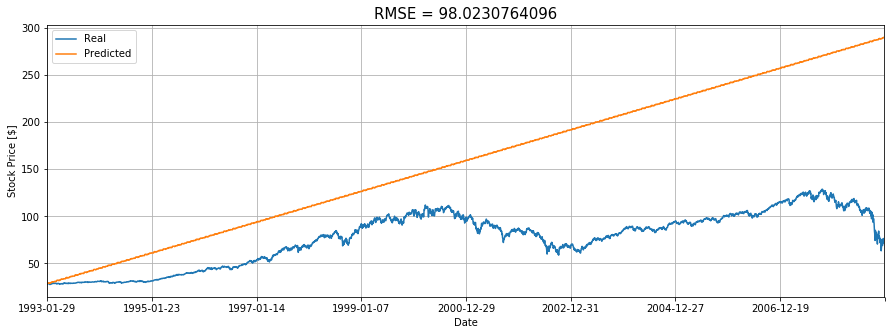

In [11]:
plt.figure(figsize=(15,5))
df['Adj Close'].plot(grid=True)
plt.plot(regression)
plt.ylabel('Stock Price [$]')
plt.legend(['Real','Predicted']);

rmse = np.sqrt(np.mean((df['Adj Close'].values - regression)**2))

plt.title('RMSE = ' + str(rmse), fontsize=15);

Our preliminary results isn't that bad. Now we can try to optimize our filter value (the standard deviation) to minimize our RMSE.

In [12]:
def std_filter(std_value):
    
    #Getting dominant values based on std_value
    meanAmp = df['amplitude'].mean()
    stdAmp = df['amplitude'].std()
    dominantAmpCheck = df['amplitude'] > (std_value*stdAmp + meanAmp) 
    positiveFreqCheck = df['freq'] > 0
    dominantAmp = df[dominantAmpCheck & positiveFreqCheck]['amplitude']
    dominantFreq = df[dominantAmpCheck & positiveFreqCheck]['freq']
    dominantTheta = df[dominantAmpCheck & positiveFreqCheck]['theta']
    
    #Calculating Regression Delta
    regressionDelta = 0
    for n in range(len(dominantTheta)):
        shift = dominantTheta[n]
        regressionDelta += dominantAmp[n] * np.cos(n * np.array(range(len(df))) + shift)

    #Converting Delta Time to Time at start value of real data    
    startValue = df['Adj Close'][0]
    regression = startValue - np.cumsum(regressionDelta)
    
    #Calculating RMSE
    rmse = np.sqrt(np.mean((df['Adj Close'].values - regression)**2))
    
    if np.isnan(rmse):
        rmse = 10000000000000
    
    return rmse

In [13]:
std_values = []
rmse_values = []

for i in np.linspace(0,2,20):
    std_values.append(i)
    rmse_values.append(std_filter(i))

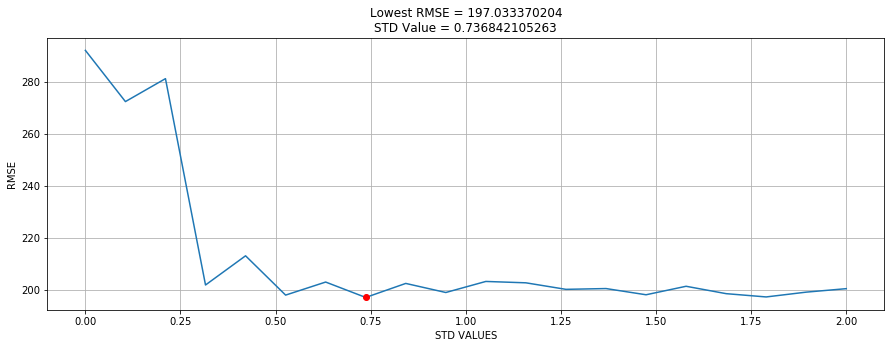

In [14]:
idx = np.array(rmse_values).argmin()
minSTD = std_values[idx]
minRMSE = rmse_values[idx]

plt.figure(figsize=(15,5))
plt.plot(std_values, rmse_values)
plt.plot(minSTD, minRMSE, 'ro')
plt.ylabel('RMSE')
plt.xlabel('STD VALUES')
plt.title('Lowest RMSE = '+str(minRMSE)+'\nSTD Value = '+str(minSTD))
plt.grid()

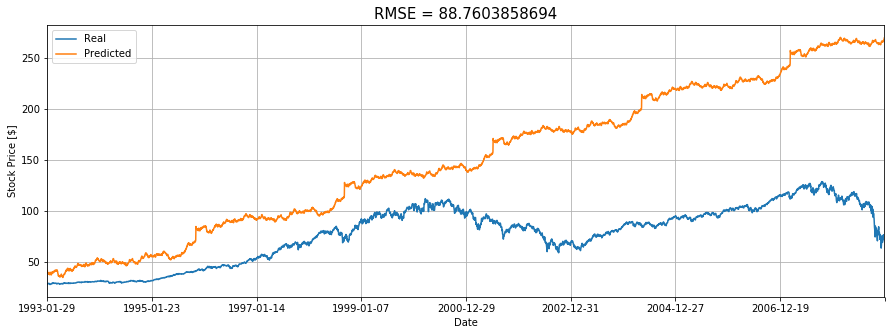

In [15]:
#Getting dominant values based on std_value
meanAmp = df['amplitude'].mean()
stdAmp = df['amplitude'].std()
dominantAmpCheck = df['amplitude'] > (minSTD*stdAmp + meanAmp) 
positiveFreqCheck = df['freq'] > 0
dominantAmp = df[dominantAmpCheck & positiveFreqCheck]['amplitude']
dominantFreq = df[dominantAmpCheck & positiveFreqCheck]['freq']
dominantTheta = df[dominantAmpCheck & positiveFreqCheck]['theta']

#Calculating Regression Delta
regressionDelta = 0
for n in range(len(dominantTheta)):
    shift = dominantTheta[n]
    regressionDelta += dominantAmp[n] * np.cos(n * np.array(range(len(df))) + shift)

#Converting Delta Time to Time at start value of real data    
startValue = df['Adj Close'][0]
regression = startValue + np.cumsum(regressionDelta)

plt.figure(figsize=(15,5))
df['Adj Close'].plot(grid=True)
plt.plot(regression)
plt.ylabel('Stock Price [$]')
plt.legend(['Real','Predicted']);

rmse = np.sqrt(np.mean((df['Adj Close'].values - regression)**2))

plt.title('RMSE = ' + str(rmse), fontsize=15);

Now let's make the prediciton after the 4000th day (marked by the red line)

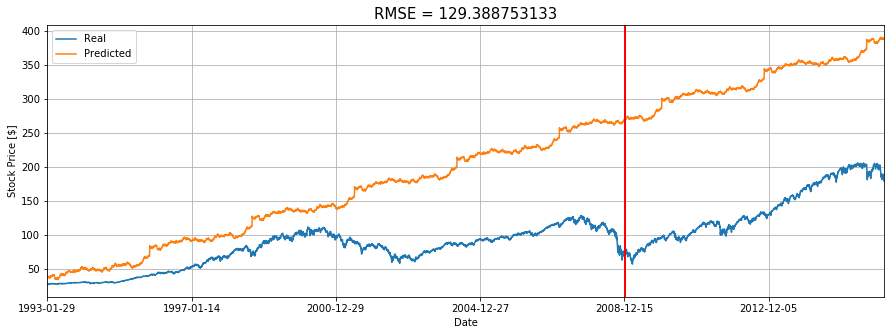

In [16]:
#Calculating Regression Delta
regressionDelta = 0
for n in range(len(dominantTheta)):
    shift = dominantTheta[n]
    regressionDelta += dominantAmp[n] * np.cos(n * np.array(range(len(df_original))) + shift)

#Converting Delta Time to Time at start value of real data    
startValue = df['Adj Close'][0]
regression = startValue + np.cumsum(regressionDelta)

plt.figure(figsize=(15,5))
df_original['Adj Close'].plot(grid=True)
plt.plot(regression)
plt.ylabel('Stock Price [$]')
plt.legend(['Real','Predicted'])

plt.axvline(x=4001, ymin=0, ymax = 1, linewidth=2, color='r')

rmse = np.sqrt(np.mean((df_original['Adj Close'].values - regression)**2))

plt.title('RMSE = ' + str(rmse), fontsize=15);